In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from __future__ import print_function, division
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import save_image

from PIL import Image 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

plt.ion()   # interactive mode

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


In [4]:
# Initialising Super Resolution CNN 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 9, padding = 2)
        self.conv2 = nn.Conv2d(64, 32, 1, padding =2)
        self.conv3 = nn.Conv2d(32,3,5,padding = 2)

    def forward(self, x):
        return self.conv3(self.conv2(self.conv1(x)))


net = Net()
net = nn.DataParallel(net)
net.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trans1 = transforms.ToTensor()


In [5]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs,path):
        'Initialization'
        self.list_IDs = list_IDs
        self.dir = path

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        pick_feature = os.path.join(self.dir,os.path.join("features",ID))
        pick_label = os.path.join(self.dir,os.path.join("label",ID))        
        # Load data and get label
        X = trans1(Image.open(pick_feature))
        Y = trans1(Image.open(pick_label))
        return X, Y


def listIDs(path): 
  walker = list(os.walk(path))
  return walker[0][2]  

In [7]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          }
max_epochs = 300

#training data loader 
train_directory = "/home/harsh.shukla/SRCNN/data/train/processed/"
trainIDs = listIDs(os.path.join(train_directory,"features"))
training_set = Dataset(trainIDs, train_directory)
training_generator = torch.utils.data.DataLoader(training_set,**params)

#test data loader 
test_directory = "/home/harsh.shukla/SRCNN/data/test/processed/"
testIDs = listIDs(os.path.join(test_directory,"features"))
test_set = Dataset(testIDs,test_directory)
test_generator = torch.utils.data.DataLoader(test_set,**params)


#Creating a Fresh Results Directory 
results = "/home/harsh.shukla/SRCNN/results"
os.mkdir(results)

In [8]:
training_loss = []
test_loss = []
count = 0
for epoch in range(max_epochs):
    # Training
    running_loss = 0.0
    validation_loss = 0.0
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(local_batch)
        loss = criterion(outputs, local_labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in test_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = net(local_batch)
            if count% 10 == 0:
                save_image(output[0],os.path.join(results,str(count) + '.png'))
            count +=1
            local_labels.require_grad = False
            # Defining our loss function, comparing the output with the target
            validation_loss += criterion(output, local_labels) 
    if epoch%2 == 0:
        print('[%d] Training_loss: %.3f' % (epoch + 1, running_loss))
        print('[%d] Validation_loss: %.3f' % (epoch + 1, validation_loss))
    training_loss.append(running_loss)
    test_loss.append(validation_loss)
    running_loss = 0.0
    validation_loss = 0.0


[1] Training_loss: 1.348
[1] Validation_loss: 0.097
[3] Training_loss: 0.201
[3] Validation_loss: 0.028
[5] Training_loss: 0.164
[5] Validation_loss: 0.020
[7] Training_loss: 0.139
[7] Validation_loss: 0.018
[9] Training_loss: 0.122
[9] Validation_loss: 0.016
[11] Training_loss: 0.110
[11] Validation_loss: 0.015
[13] Training_loss: 0.105
[13] Validation_loss: 0.014
[15] Training_loss: 0.098
[15] Validation_loss: 0.014
[17] Training_loss: 0.094
[17] Validation_loss: 0.013
[19] Training_loss: 0.090
[19] Validation_loss: 0.013
[21] Training_loss: 0.089
[21] Validation_loss: 0.012
[23] Training_loss: 0.086
[23] Validation_loss: 0.012
[25] Training_loss: 0.084
[25] Validation_loss: 0.012
[27] Training_loss: 0.084
[27] Validation_loss: 0.012
[29] Training_loss: 0.082
[29] Validation_loss: 0.012
[31] Training_loss: 0.080
[31] Validation_loss: 0.011
[33] Training_loss: 0.080
[33] Validation_loss: 0.011
[35] Training_loss: 0.078
[35] Validation_loss: 0.011
[37] Training_loss: 0.078
[37] Validat

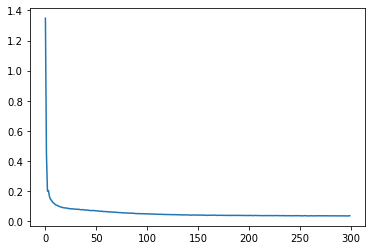

In [9]:
plt.plot(training_loss)

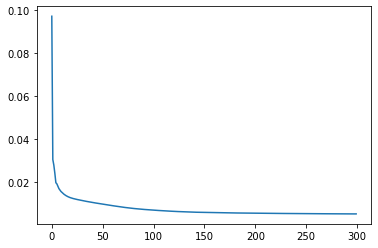

In [10]:
plt.plot(test_loss)